# XOR 문제

퍼셉트론, SMV같은 선형판별함수를 이용하는 분류모델은 직선을 이용하기에 다음과 같은 XOR문제를 해결하지 못한다는 단점이 있다.

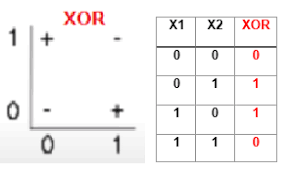

다음과 같은 데이터의 경우 선형한펼함수 분류모형으로 두 클래스를 분류할 수 없다.

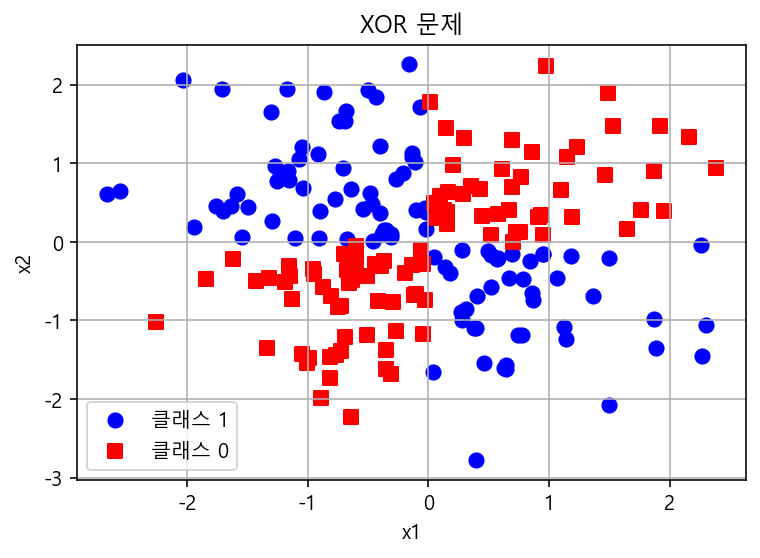

In [10]:
np.random.seed(0)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, 0)
plt.scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1],
            c='b', marker='o', label='클래스 1', s=50)
plt.scatter(X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1],
            c='r', marker='s', label='클래스 0', s=50)
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("XOR 문제")
plt.grid()
plt.show()

실제로 SVM을 이용해 XOR 문제를 풀어보면 풀지 못한다는 것을 알 수 있다.

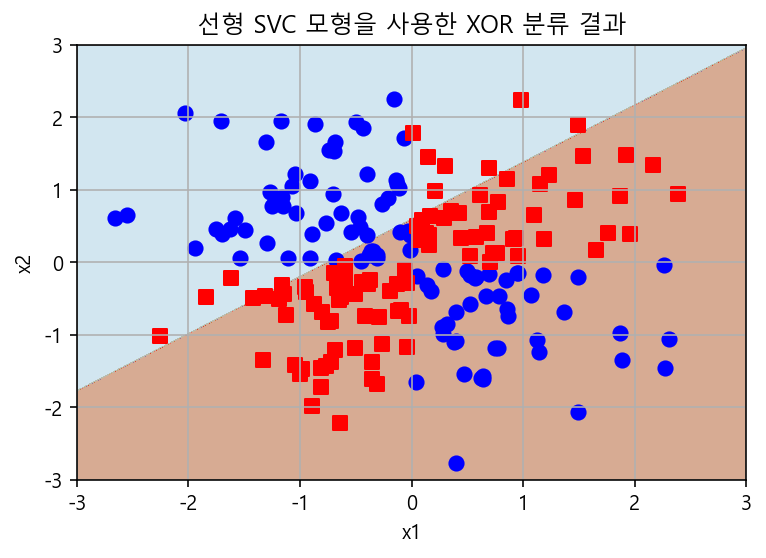

In [11]:
def plot_xor(X, y, model, title, xmin=-3, xmax=3, ymin=-3, ymax=3):
    XX, YY = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/1000),
                         np.arange(ymin, ymax, (ymax-ymin)/1000))
    ZZ = np.reshape(model.predict(
        np.array([XX.ravel(), YY.ravel()]).T), XX.shape)
    plt.contourf(XX, YY, ZZ, cmap=mpl.cm.Paired_r, alpha=0.5)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='b',
                marker='o', label='클래스 1', s=50)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='r',
                marker='s', label='클래스 0', s=50)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")

from sklearn.svm import SVC

svc = SVC(kernel="linear").fit(X_xor, y_xor)
plot_xor(X_xor, y_xor, svc, "선형 SVC 모형을 사용한 XOR 분류 결과")
plt.grid()
plt.show()

# 기저함수

따라서 위와 같은 XOR 문제를 해결하기 위해선 비선형 판별모형을 만들어야하는데 이는 쉽지 않은 작업이다.

따라서 비선형판별모형을 만드는 대신 선형판별모형을 사용하는데 독립변수 벡터 $x$ 대신 기저함수로 변환한 $M$차원 벡터 $\phi(x)$를 독립변수 벡터로 사용한다.

즉, $x$에 대해선 비선형이지만 $w$에 대해선 선형인 분류모델을 생성하는 것이다.

$$f=w^Tx \rightarrow f = w^T\phi(x)$$

$$x=(x_1, x_2, \cdots, x_D) \;\;\; \rightarrow \;\;\; \phi(x) = (\phi_1(x), \phi_2(x), \cdots, \phi_M(x))$$

위의 XOR 문제를 풀기 위해 다음과 같은 변환함수를 만들어보면 XOR문제의 클래스를 분류할 수 있다.

$$(x_1, x_2) \;\;\; \rightarrow \;\;\; \phi(x) = (x_1^2, \sqrt{2}x_1x_2)$$

In [12]:
X = np.arange(6).reshape(3, 2)
X

array([[0, 1],
       [2, 3],
       [4, 5]])

In [13]:
from sklearn.preprocessing import FunctionTransformer

def basis(X):
    return np.vstack([X[:, 0]**2, np.sqrt(2)*X[:, 0]*X[:, 1]]).T

FunctionTransformer(basis).fit_transform(X)

array([[ 0.        ,  0.        ],
       [ 4.        ,  8.48528137],
       [16.        , 28.28427125]])

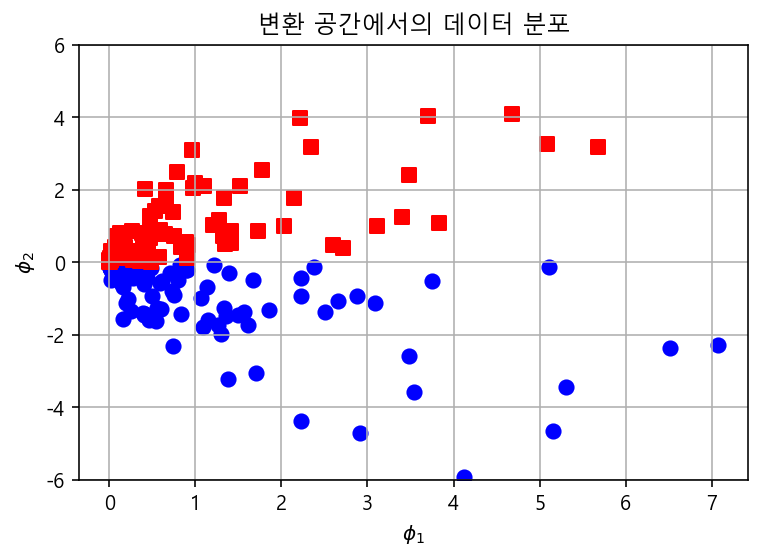

In [14]:
X_xor2 = FunctionTransformer(basis).fit_transform(X_xor)
plt.scatter(X_xor2[y_xor == 1, 0], X_xor2[y_xor == 1, 1], c="b", marker='o', s=50)
plt.scatter(X_xor2[y_xor == 0, 0], X_xor2[y_xor == 0, 1], c="r", marker='s', s=50)
plt.ylim(-6, 6)
plt.title("변환 공간에서의 데이터 분포")
plt.xlabel(r"$\phi_1$")
plt.ylabel(r"$\phi_2$")
plt.grid()
plt.show()

위의 변환함수를 이용해 XOR문제를 해결한 결과 SVC의 판별 경계선은 다음과 같이 변한다.

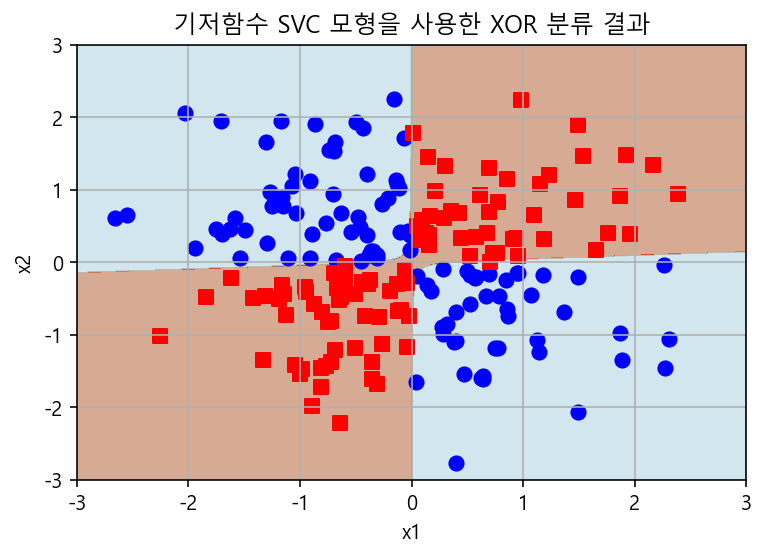

In [15]:
from sklearn.pipeline import Pipeline

basismodel = Pipeline([("basis", FunctionTransformer(basis)), 
                       ("svc", SVC(kernel="linear"))]).fit(X_xor, y_xor)
plot_xor(X_xor, y_xor, basismodel, "기저함수 SVC 모형을 사용한 XOR 분류 결과")
plt.grid()
plt.show()

# 커널트릭

SVM의 경우 Loss function과 Model의 수식을 Dual form으로 표현하면 다음과 같다.

$$L =  \sum_{n=1}^N a_n - \dfrac{1}{2}\sum_{n=1}^N\sum_{m=1}^N a_n a_m y_n y_m x_n^T x_m$$

$$y = w^T x - w_0 = \sum_{n=1}^N a_n y_n x_n^T x - w_0$$

여기서 위의 XOR문제를 해결한 것과 같이 $x$를 기저함수로 변환해 $\phi(x)$로 변환하면 다음과 같다.

$$L =  \sum_{n=1}^N a_n - \dfrac{1}{2}\sum_{n=1}^N\sum_{m=1}^N a_n a_m y_n y_m \phi(x_n)^T \phi(x_m)$$

$$y = w^T x - w_0 = \sum_{n=1}^N a_n y_n \phi(x_n)^T \phi(x) - w_0$$

위 식을 통해 결과적으로 여러개의 기저함수를 생각하지 않고 하나의 함수로 나타내는 방법론이 생겨났는데 이러한 함수를 바로 커널(kernel)이라고 한다.

$$k(x_i, x_j) = \phi(x_i)^T \phi(x_j)$$

# 주로 사용되는 커널

## Linear SVM

$$k(x_1, x_2) = x_1^Tx_2$$

## Polynomial Kernel

다항커널은 벡터의 내적으로 정의된 커널을 확장하여 만든 커널이다.

$$k(x_1, x_2) = (\gamma (x_1^Tx_2) + \theta)^d$$

예를 들어 $\gamma=1, \theta=1, d=4, x=$스칼라인 경우 다음과 같은 다항식이 된다.

$$\begin{split} 
\begin{eqnarray}
k(x_1, x_2) 
&=& (x_1^Tx_2 + 1)^4 \\
&=& x_1^4x_2^4 + 4x_1^3x_2^3 + 6x_1^2x_2^2 + 4x_1x_2 + 1 \\
&=& (x_1^4, 2x_1^3, \sqrt{6}x_1, 2x_1, 1)^T (x_2^4, 2x_2^3, \sqrt{6}x_2, 2x_2, 1) \ \\
\end{eqnarray}
\end{split}$$

즉, 위 식은 아래의 5개의 기저함수를 가진 모형이 된다.

$$\phi_1(x)=x^4$$

$$\phi_2(x)=2x^3$$

$$\phi_3(x)=\sqrt{6}x^2$$

$$\phi_4(x)=2x$$

$$\phi_5(x)=1$$

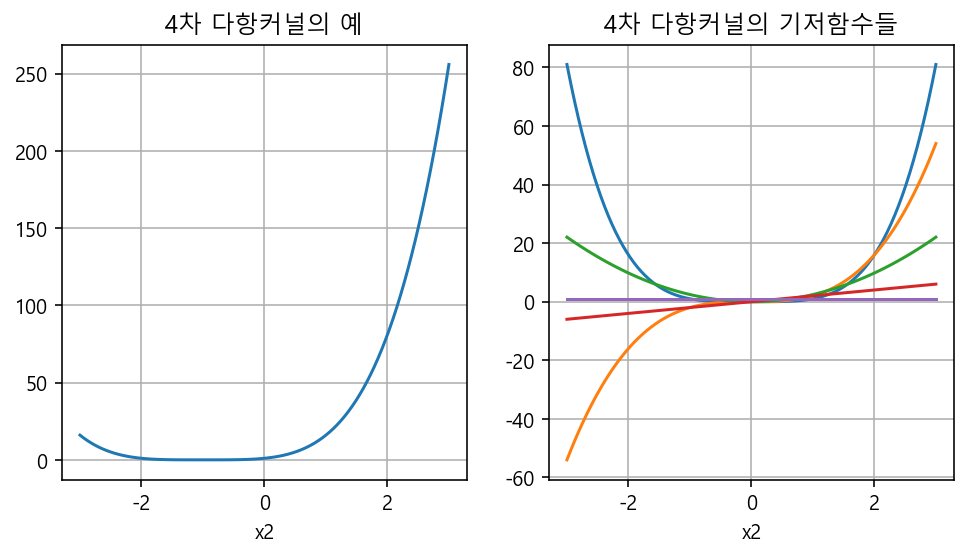

In [16]:
x1 = 1
x2 = np.linspace(-3, 3, 100)

def poly4(x1, x2):
    return (x1 * x2 + 1) ** 4

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(x2, poly4(x1, x2), ls="-")
plt.xlabel("x2")
plt.title("4차 다항커널의 예")
plt.grid()
plt.subplot(122)
plt.plot(x2, x2 ** 4)
plt.plot(x2, 2 * x2 ** 3)
plt.plot(x2, np.sqrt(6) * x2 ** 2)
plt.plot(x2, 2 * x2)
plt.plot(x2, np.ones_like(x2))
plt.xlabel("x2")
plt.title("4차 다항커널의 기저함수들")
plt.grid()
plt.show()

## RBF(Radial Basis Function) or Gaussian Kernel

$$k(x_1, x_2) = \exp \left( -\gamma ||x_1-x_2||^2 \right)$$

RBF커널 혹은 가우시안 커널에서 $\gamma=\dfrac{1}{2}$, $||x_1|| = ||x_2|| =1$로 가정한다면 다음과 같은 차수가 무한대인 다항커널이 된다.

$$\begin{split} 
\begin{eqnarray}
k(x_1, x_2) 
&=& \exp{\left(-\frac{||x_1 - x_2||^2}{2}\right)} \\
&=& \exp{\left(-\frac{x_1^Tx_1}{2} - \frac{x_2^Tx_2}{2} + 2x_1^Tx_2 \right)} \\
&=& \exp{\left(-\frac{x_1^Tx_1}{2}\right)}\exp{\left(-\frac{x_2^Tx_2}{2}\right)}\exp{(x_1^Tx_2)} \\
&=& C \exp{(x_1^Tx_2)} \\
&\approx& C \left( 1 + (x_1^Tx_2) + \dfrac{1}{2!}(x_1^Tx_2)^2 +  \dfrac{1}{3!}(x_1^Tx_2)^3 + \cdots \right) \\
\end{eqnarray}
\end{split}$$

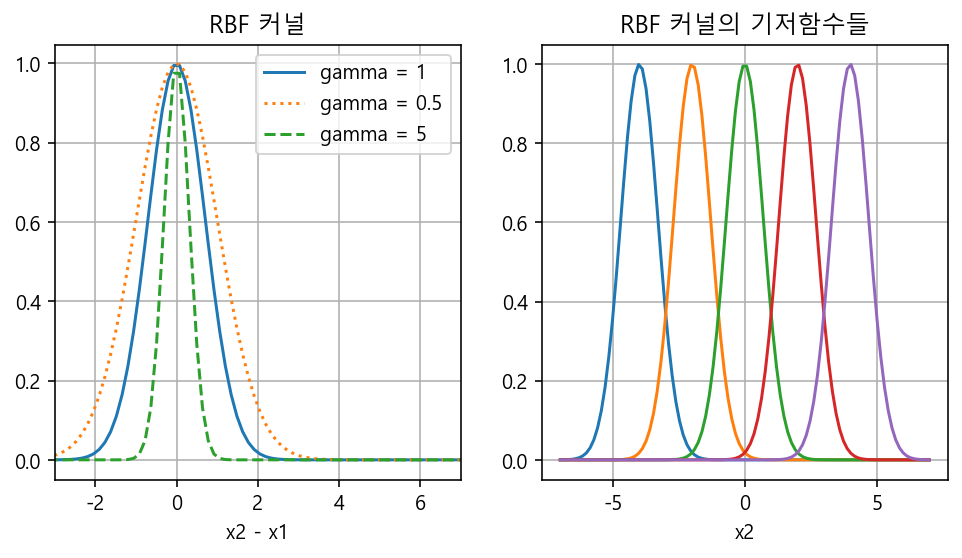

In [17]:
x1 = 0.0
x2 = np.linspace(-7, 7, 100)

def rbf(x1, x2, gamma):
    return np.exp(-gamma * np.abs(x2 - x1) ** 2)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(x2, rbf(x1, x2, 1), ls="-", label="gamma = 1")
plt.plot(x2, rbf(x1, x2, 0.5), ls=":", label="gamma = 0.5")
plt.plot(x2, rbf(x1, x2, 5), ls="--", label="gamma = 5")
plt.xlabel("x2 - x1")
plt.xlim(-3, 7)
plt.legend(loc=1)
plt.title("RBF 커널")
plt.grid()
plt.subplot(122)
plt.plot(x2, rbf(-4, x2, 1))
plt.plot(x2, rbf(-2, x2, 1))
plt.plot(x2, rbf(0, x2, 1))
plt.plot(x2, rbf(2, x2, 1))
plt.plot(x2, rbf(4, x2, 1))
plt.xlabel("x2")
plt.title("RBF 커널의 기저함수들")
plt.grid()
plt.show()

## Sigmoid Kernel

$$k(x_1, x_2) = \tanh(\gamma (x_1^Tx_2) + \theta)$$

# sklearn - SVM

sklearn에서 SVM일 사용할 때 kernel 파라미터를 이용해 커널을 지정할 수 있다.

- linear : 선형SVM
- poly : 다항커널
    - gamma: $\gamma$
    - coef0 : $\theta$
    - degree : $d$
- rbf or None : RBF커널
    - gamma : $\gamma$
- sigmoid
    - gamma : $\gamma$
    - coef0 : $\theta$

위의 XOR문제를 다향한 커널을 이용해 분류하면 다음과 같은 차이점을 보인다.

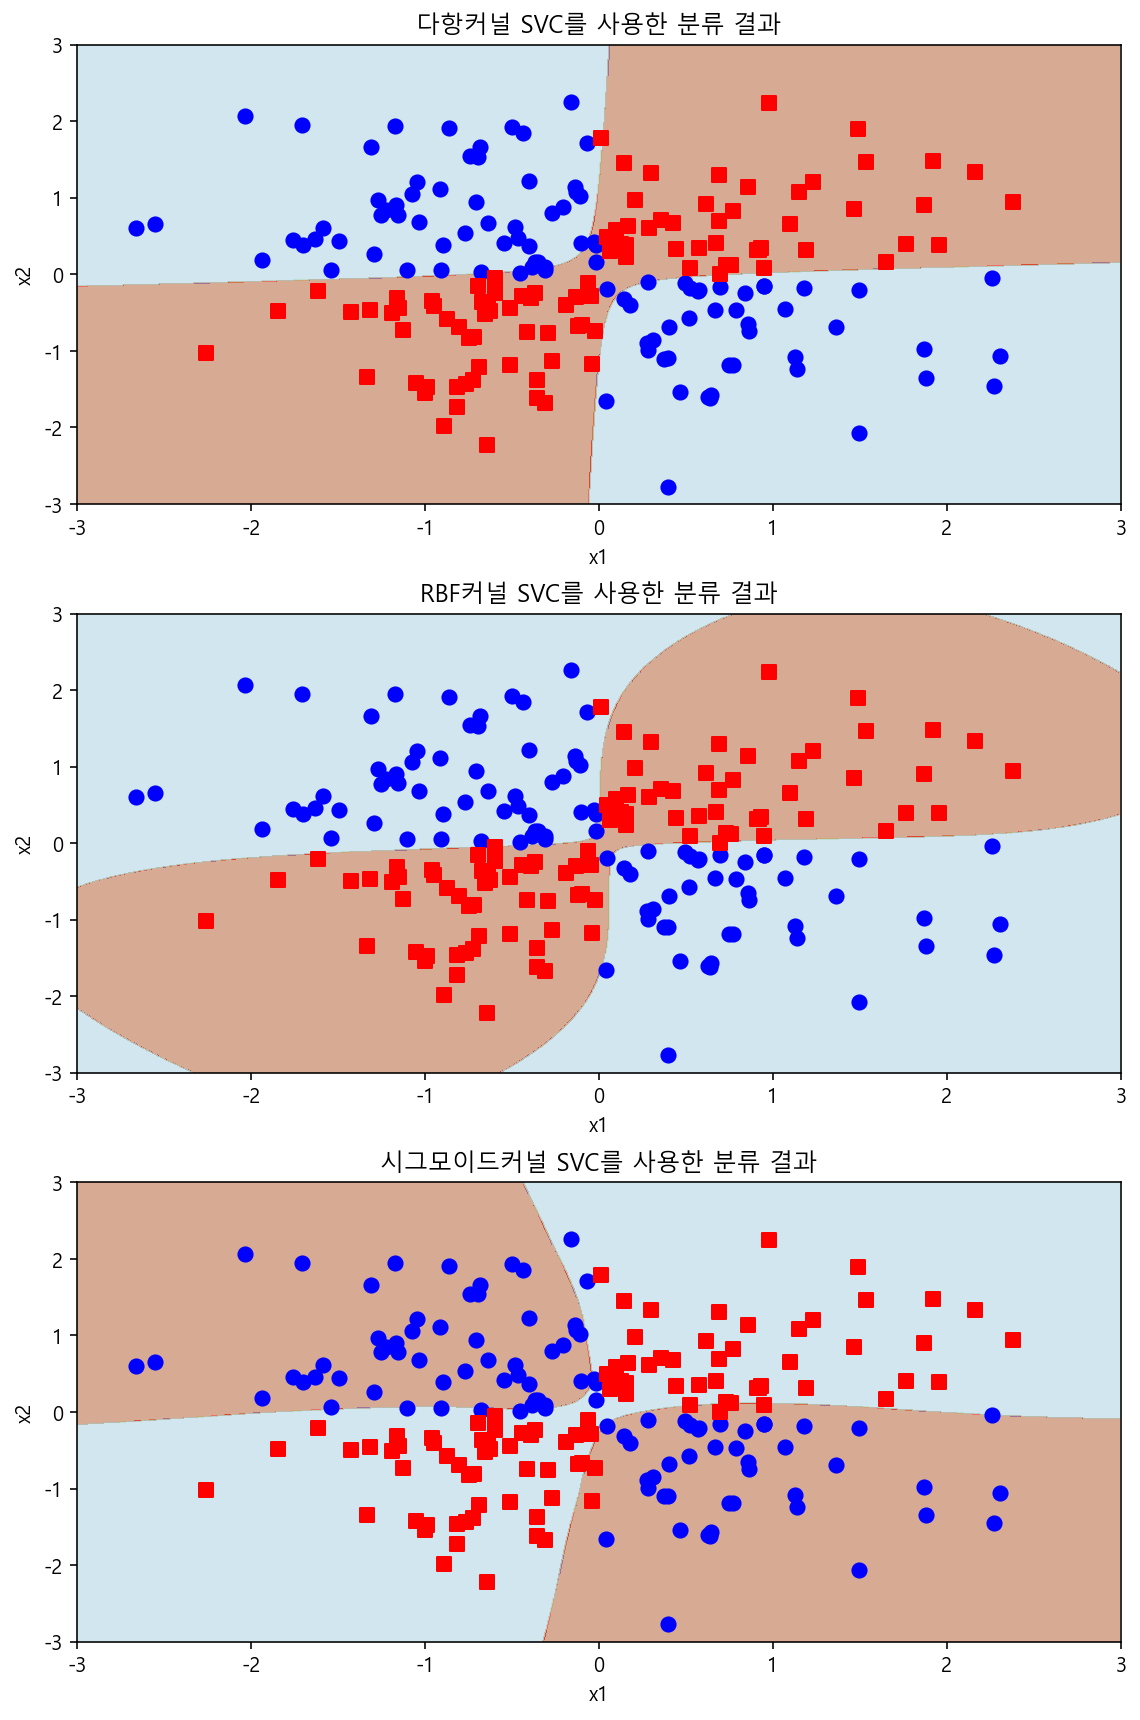

In [18]:
polysvc = SVC(kernel="poly", degree=2, gamma=1, coef0=0).fit(X_xor, y_xor)
rbfsvc = SVC(kernel="rbf").fit(X_xor, y_xor)
sigmoidsvc = SVC(kernel="sigmoid", gamma=2, coef0=2).fit(X_xor, y_xor)

plt.figure(figsize=(8, 12))
plt.subplot(311)
plot_xor(X_xor, y_xor, polysvc, "다항커널 SVC를 사용한 분류 결과")
plt.subplot(312)
plot_xor(X_xor, y_xor, rbfsvc, "RBF커널 SVC를 사용한 분류 결과")
plt.subplot(313)
plot_xor(X_xor, y_xor, sigmoidsvc, "시그모이드커널 SVC를 사용한 분류 결과")
plt.tight_layout()
plt.show()

## 커널 파라미터 조정

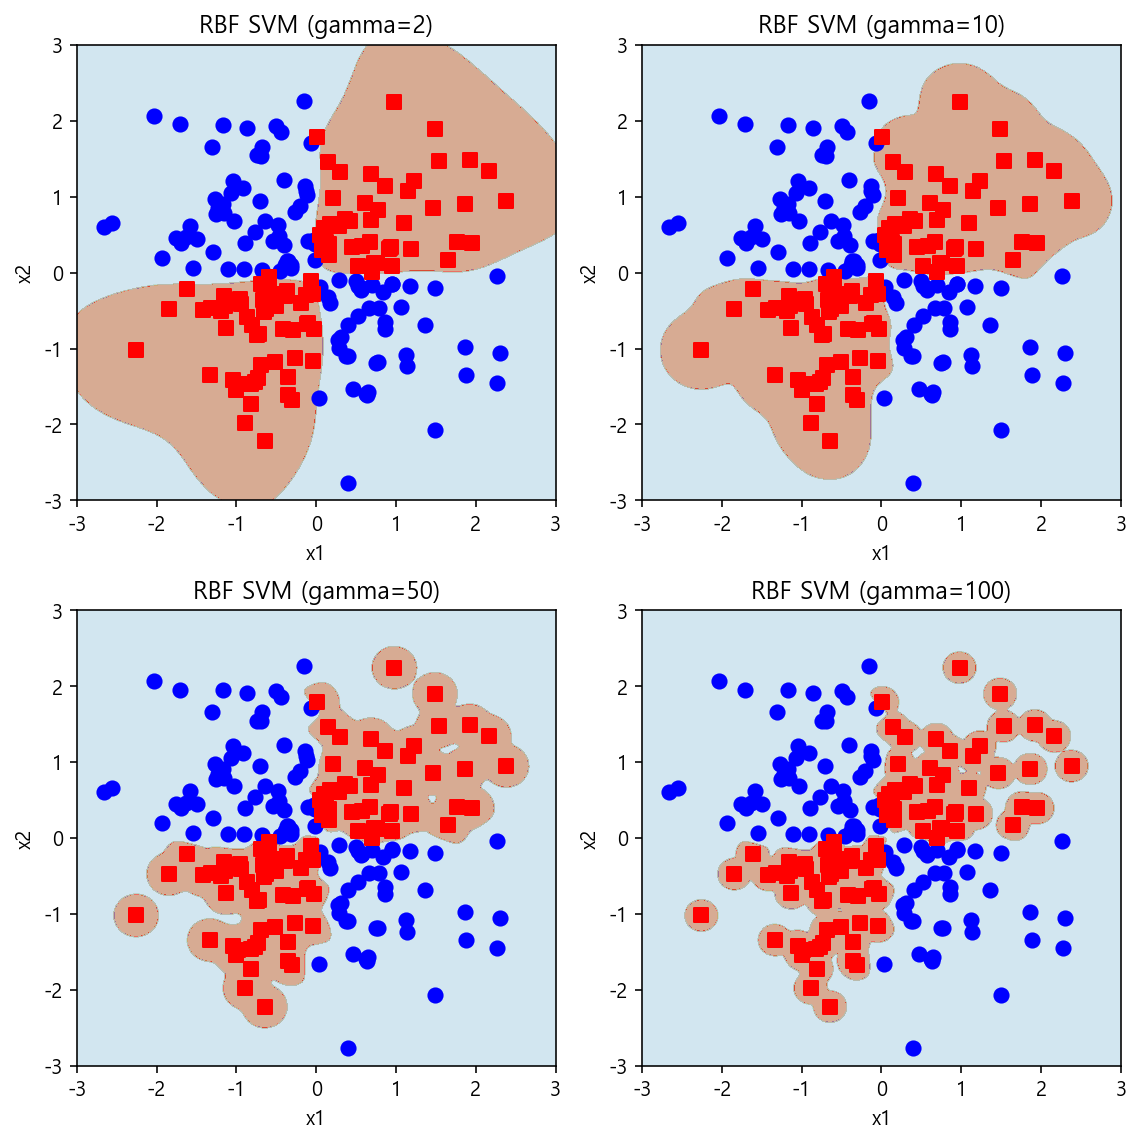

In [19]:
plt.figure(figsize=(8, 8))
plt.subplot(221)
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=2).fit(X_xor, y_xor), "RBF SVM (gamma=2)")
plt.subplot(222)
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=10).fit(X_xor, y_xor), "RBF SVM (gamma=10)")
plt.subplot(223)
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=50).fit(X_xor, y_xor), "RBF SVM (gamma=50)")
plt.subplot(224)
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=100).fit(X_xor, y_xor), "RBF SVM (gamma=100)")
plt.tight_layout()
plt.show()

## 커널 SVM을 이용한 IRIS 데이터 분류

In [32]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# IRIS 데이터 로드
iris = load_iris()

# 시각화 편의를 위해 petal length, petal width만 이용
X = iris.data[:, [2, 3]]
y = iris.target

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Scaling
sc = StandardScaler()
sc.fit(X_train)

# prepare data for training
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

In [34]:
# 시각화 함수 정의

def plot_iris(X, y, model, title, xmin=-2.5, xmax=2.5, ymin=-2.5, ymax=2.5):
    XX, YY = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/1000),
                         np.arange(ymin, ymax, (ymax-ymin)/1000))
    ZZ = np.reshape(model.predict(np.array([XX.ravel(), YY.ravel()]).T), XX.shape)
    plt.contourf(XX, YY, ZZ, cmap=mpl.cm.Paired_r, alpha=0.5)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='r', marker='^', label='0', s=100)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='g', marker='o', label='1', s=100)
    plt.scatter(X[y == 2, 0], X[y == 2, 1], c='b', marker='s', label='2', s=100)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel("꽃잎의 길이")
    plt.ylabel("꽃잎의 폭")
    plt.grid()
    plt.title(title)

In [36]:
# 모델 생성

model1 = SVC(kernel='linear').fit(X_test_std, y_test)
model2 = SVC(kernel='poly', random_state=0,
             gamma=10, C=1.0).fit(X_test_std, y_test)
model3 = SVC(kernel='rbf', random_state=0, gamma=1,
             C=1.0).fit(X_test_std, y_test)

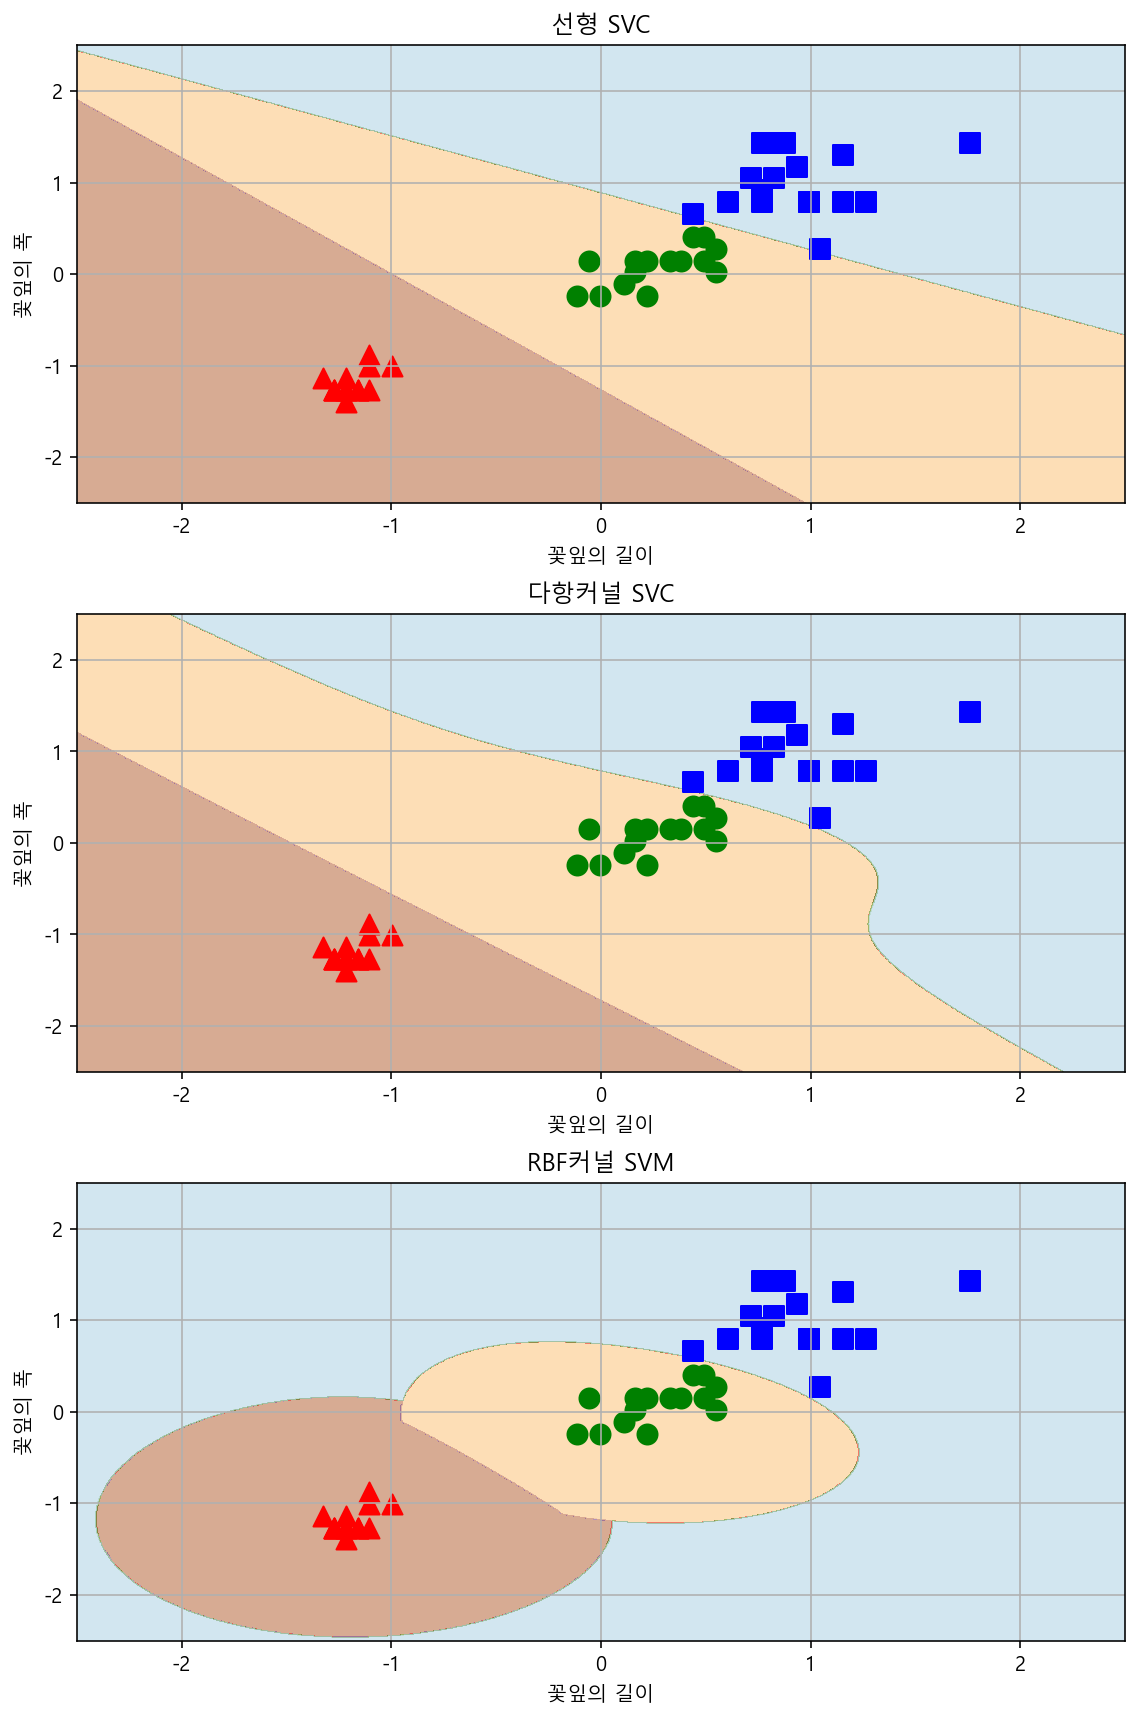

In [38]:
# 모델별 판별경계선 비교

plt.figure(figsize=(8, 12))
plt.subplot(311)
plot_iris(X_test_std, y_test, model1, "선형 SVC")
plt.subplot(312)
plot_iris(X_test_std, y_test, model2, "다항커널 SVC")
plt.subplot(313)
plot_iris(X_test_std, y_test, model3, "RBF커널 SVM")
plt.tight_layout()
plt.show()